# Training process 5
+ Model name：`Training_5_Res_NLLLoss_1FC_100e_SP.pt` ; 
+ Path： '`./model/Training_5_Res_NLLLoss_1FC_100e_SP.pt`'
+ Training network：`resnet50 with One fully connected layers with samplepairing`
+ Loss function：`NLLLoss`
+ Optimizer： `Adam`
+ epoch： `100`
+ sample pairing: `False ` 

### Data Preparation

In [1]:
import torch
import torchvision
from torchvision import datasets,transforms 
from face_crop import face_crop


train_dir = './data/face_data/train/'
valid_dir = './data/face_data/val/'

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
    transforms.RandomErasing(),
])


valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128,
                                           shuffle=True, num_workers=4)


valid_data = datasets.ImageFolder(root=valid_dir,
                                transform=valid_transform)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64,
                                          shuffle=True, num_workers=4)


In [2]:
train_data

Dataset ImageFolder
    Number of datapoints: 10481
    Root location: ./data/face_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [3]:
valid_data

Dataset ImageFolder
    Number of datapoints: 6821
    Root location: ./data/face_data/val/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [4]:
class_names = train_data.classes

In [5]:
import random
from PIL import Image
import numpy as np
import torchvision.datasets as vdatasets


class SamplePairing(object):
    def __init__(self, p = 0.5):
        self.p = p

    def __call__(self, img_a, img_b):
        # 0.7 的概率执行 samplepairing
        toss = np.random.choice([1, 0], p=[self.p, 1 - self.p])
        
        if toss:
            img_a_array = img_a.numpy().copy()
            img_b_array = img_b.numpy().copy()
            
            # mix two images
            mean_img = np.mean([img_a_array, img_b_array], axis=0)
            img = torch.from_numpy(mean_img)
        
            return img
        else:
            return img_a

/home/wang/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


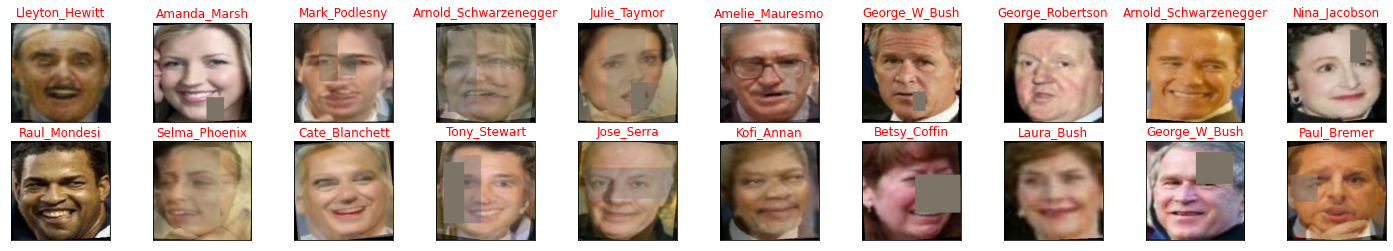

In [6]:
#Transform Data visualize
import numpy as np
import matplotlib.pyplot as plt
images, classes = next(iter(train_loader))

for i in range(images.shape[0]):
    image_sample = SamplePairing()
    image_a = images[i]
    image_b = images[np.random.randint(0, images.shape[0])]
    images[i] = image_sample(image_a, image_b)

def imshow(inp):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    

fig = plt.figure(figsize=(25, 4))
    # display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(class_names[classes[idx]], color='red') 

### Training Network

In [7]:
# Resnet50 with One fully connected layers
from torchvision import models
from torch import nn
from collections import OrderedDict

model_resnet50 = models.resnet50(pretrained=True)
for param in model_resnet50.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc', nn.Linear(2048, len(class_names))),
    ('output', nn.LogSoftmax(dim=1))
]))

# Replace the classifier part of the introduced net!
model_resnet50.fc = classifier

In [8]:
#model_resnet50

## Trainning process

In [10]:
import torch 
import torch.nn.functional as F
from torch import nn, optim  
from tqdm import tqdm
import numpy as np
from focal_loss import FocalLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model='resnet50', data_augumentation=False, loss='NLLLoss', lr=0.003, weight_decay=1e-5, epoch=None):
    if model == 'model_resnet50':
        model = model_resnet50
    
    model.to(device)
    
    if data_augumentation:
        pass
        
    if loss == 'NLLLoss':
        print('use NLLLoss')
        criterion = nn.NLLLoss()
        
    if loss == 'FocalLoss':
        print('use focal loss')
        criterion = FocalLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)    
    
    
    epochs = epoch
    train_losses, valid_losses = [], []
    valid_loss_min = np.inf

    for e in range(epochs):
        train_loss = 0
        valid_loss = 0
        accuracy = 0.0

        model.train()
        for images, labels in tqdm(train_loader):
            if data_augumentation == 'samplePairing' and e+1 >= epochs * 0.2 and e+1 < epochs * 0.8:
                # do sample pairing for every image
                for i in range(images.shape[0]):
                    image_sample = SamplePairing()
                    image_a = images[i]
                    image_b = images[np.random.randint(0, images.shape[0])]
                    # images[i] is of type tensor, and both inputs are of type tensor
                    images[i] = image_sample(image_a, image_b)
                    
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss = loss.requires_grad_()
            loss.backward()

            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()  # Close dropout
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                
                # Verify loss
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item() * images.size(0)
                
                # Verify accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # An epoch loss 
        train_loss = train_loss/len(train_loader.sampler)   
        valid_loss = valid_loss/len(valid_loader.sampler)
        valid_accuracy = accuracy / len(valid_loader)

        # Add the loss to the list for graphing
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        # Add the code to save this list to the local to use this loss transformation list when not training in the future, 
        # such as comparing different models
        train_loss_array = np.array(train_losses)
        valid_loss_array = np.array(valid_losses)
        valid_accuracy_array = np.array(valid_accuracy)
        
        
        np.save('./results/Training_5/Ftp5_train_loss_array.npy', train_loss_array)
        np.save('./results/Training_5/Ftp5_valid_loss_array.npy', valid_loss_array)
        np.save('./results/Training_5/Ftp5_valid_accuracy_array.npy', valid_accuracy_array)
        
   
        # Print an epoch information
        print('Epoch {}/{}..'.format(e + 1, epochs),
              'Train loss:{:.4f}..'.format(train_loss),
              'Valid loss:{:.4f}..'.format(valid_loss),
              'Valid accuracy:{:.4f}%..'.format(valid_accuracy * 100))
        
        # Save the optimal model
        if valid_loss <= valid_loss_min:
            print('valid_loss decreased: ({:.4f} --> {:.4f}), saving model "Training_5_Res_NLLLoss_1FC_100e_SP.pt"..'.format(valid_loss_min, valid_loss))
            torch.save(model, './model/Training_5_Res_NLLLoss_1FC_100e_SP.pt')
            valid_loss_min = valid_loss

In [10]:
train(model='model_resnet50', data_augumentation='samplePairing', loss='NLLLoss', lr=0.001, weight_decay=1e-5, epoch=100)

  0%|          | 0/82 [00:00<?, ?it/s]

use NLLLoss


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/wang/anaconda3/envs/nn_last/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of 

Epoch 1/100.. Train loss:10.0614.. Valid loss:8.5561.. Valid accuracy:2.3949%..
valid_loss decreased: (inf --> 8.5561), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 2/100.. Train loss:8.1264.. Valid loss:8.0935.. Valid accuracy:2.7414%..
valid_loss decreased: (8.5561 --> 8.0935), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:52<00:00,  1.05s/it]


Epoch 3/100.. Train loss:7.4766.. Valid loss:7.4937.. Valid accuracy:4.7313%..
valid_loss decreased: (8.0935 --> 7.4937), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 4/100.. Train loss:6.8738.. Valid loss:6.9574.. Valid accuracy:7.4581%..
valid_loss decreased: (7.4937 --> 6.9574), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:55<00:00,  1.08s/it]


Epoch 5/100.. Train loss:6.3481.. Valid loss:6.4725.. Valid accuracy:10.8077%..
valid_loss decreased: (6.9574 --> 6.4725), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 6/100.. Train loss:5.8684.. Valid loss:6.0023.. Valid accuracy:16.1736%..
valid_loss decreased: (6.4725 --> 6.0023), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 7/100.. Train loss:5.4303.. Valid loss:5.6065.. Valid accuracy:20.5146%..
valid_loss decreased: (6.0023 --> 5.6065), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 8/100.. Train loss:4.9946.. Valid loss:5.2185.. Valid accuracy:27.4087%..
valid_loss decreased: (5.6065 --> 5.2185), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 9/100.. Train loss:4.6486.. Valid loss:4.9337.. Valid accuracy:28.7281%..
valid_loss decreased: (5.2185 --> 4.9337), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:55<00:00,  1.08s/it]


Epoch 10/100.. Train loss:4.3189.. Valid loss:4.5740.. Valid accuracy:33.3706%..
valid_loss decreased: (4.9337 --> 4.5740), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 11/100.. Train loss:3.9892.. Valid loss:4.3531.. Valid accuracy:38.0154%..
valid_loss decreased: (4.5740 --> 4.3531), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 12/100.. Train loss:3.7395.. Valid loss:4.0837.. Valid accuracy:43.0191%..
valid_loss decreased: (4.3531 --> 4.0837), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [02:01<00:00,  1.13s/it]


Epoch 13/100.. Train loss:3.4685.. Valid loss:3.8926.. Valid accuracy:47.4942%..
valid_loss decreased: (4.0837 --> 3.8926), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [02:07<00:00,  1.19s/it]


Epoch 14/100.. Train loss:3.2514.. Valid loss:3.7543.. Valid accuracy:48.8444%..
valid_loss decreased: (3.8926 --> 3.7543), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [02:05<00:00,  1.17s/it]


Epoch 15/100.. Train loss:3.0577.. Valid loss:3.6066.. Valid accuracy:51.8021%..
valid_loss decreased: (3.7543 --> 3.6066), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [02:05<00:00,  1.18s/it]


Epoch 16/100.. Train loss:2.8614.. Valid loss:3.5063.. Valid accuracy:53.6515%..
valid_loss decreased: (3.6066 --> 3.5063), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [02:04<00:00,  1.17s/it]


Epoch 17/100.. Train loss:2.7180.. Valid loss:3.3660.. Valid accuracy:55.6241%..
valid_loss decreased: (3.5063 --> 3.3660), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [02:04<00:00,  1.17s/it]


Epoch 18/100.. Train loss:2.5789.. Valid loss:3.3176.. Valid accuracy:56.2508%..
valid_loss decreased: (3.3660 --> 3.3176), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [02:05<00:00,  1.17s/it]


Epoch 19/100.. Train loss:2.4283.. Valid loss:3.2328.. Valid accuracy:57.7734%..
valid_loss decreased: (3.3176 --> 3.2328), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 20/100.. Train loss:4.9967.. Valid loss:3.7066.. Valid accuracy:48.7422%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 21/100.. Train loss:4.8701.. Valid loss:3.5998.. Valid accuracy:51.7026%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 22/100.. Train loss:4.8256.. Valid loss:3.5971.. Valid accuracy:51.0427%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 23/100.. Train loss:4.7497.. Valid loss:3.4997.. Valid accuracy:53.3247%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 24/100.. Train loss:4.6467.. Valid loss:3.4753.. Valid accuracy:54.3619%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 25/100.. Train loss:4.5814.. Valid loss:3.4523.. Valid accuracy:54.0777%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 26/100.. Train loss:4.5797.. Valid loss:3.3599.. Valid accuracy:56.3502%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 27/100.. Train loss:4.5797.. Valid loss:3.3621.. Valid accuracy:55.2511%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 28/100.. Train loss:4.5137.. Valid loss:3.3551.. Valid accuracy:55.8605%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 29/100.. Train loss:4.4918.. Valid loss:3.2976.. Valid accuracy:56.9663%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 30/100.. Train loss:4.4198.. Valid loss:3.2872.. Valid accuracy:57.5051%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 31/100.. Train loss:4.4422.. Valid loss:3.3117.. Valid accuracy:56.4406%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 32/100.. Train loss:4.3910.. Valid loss:3.2968.. Valid accuracy:56.5985%..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 33/100.. Train loss:4.3641.. Valid loss:3.2098.. Valid accuracy:59.1781%..
valid_loss decreased: (3.2328 --> 3.2098), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 34/100.. Train loss:4.3127.. Valid loss:3.1986.. Valid accuracy:59.0557%..
valid_loss decreased: (3.2098 --> 3.1986), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 35/100.. Train loss:4.3332.. Valid loss:3.1711.. Valid accuracy:59.0281%..
valid_loss decreased: (3.1986 --> 3.1711), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 36/100.. Train loss:4.2953.. Valid loss:3.1921.. Valid accuracy:59.1635%..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 37/100.. Train loss:4.2779.. Valid loss:3.1497.. Valid accuracy:59.8672%..
valid_loss decreased: (3.1711 --> 3.1497), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 38/100.. Train loss:4.2159.. Valid loss:3.1773.. Valid accuracy:59.0731%..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 39/100.. Train loss:4.1879.. Valid loss:3.1357.. Valid accuracy:60.4817%..
valid_loss decreased: (3.1497 --> 3.1357), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 40/100.. Train loss:4.2331.. Valid loss:3.0873.. Valid accuracy:60.8519%..
valid_loss decreased: (3.1357 --> 3.0873), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 41/100.. Train loss:4.2447.. Valid loss:3.1614.. Valid accuracy:60.0874%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 42/100.. Train loss:4.0920.. Valid loss:3.0917.. Valid accuracy:61.2596%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 43/100.. Train loss:4.1127.. Valid loss:3.1137.. Valid accuracy:60.7895%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 44/100.. Train loss:4.1262.. Valid loss:3.0947.. Valid accuracy:60.7524%..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 45/100.. Train loss:4.0948.. Valid loss:3.0776.. Valid accuracy:61.0977%..
valid_loss decreased: (3.0873 --> 3.0776), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 46/100.. Train loss:4.1026.. Valid loss:3.1124.. Valid accuracy:61.0192%..


100%|██████████| 107/107 [01:55<00:00,  1.08s/it]


Epoch 47/100.. Train loss:4.0611.. Valid loss:3.0772.. Valid accuracy:61.7920%..
valid_loss decreased: (3.0776 --> 3.0772), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 48/100.. Train loss:4.1114.. Valid loss:3.0541.. Valid accuracy:61.6842%..
valid_loss decreased: (3.0772 --> 3.0541), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 49/100.. Train loss:4.0531.. Valid loss:3.0210.. Valid accuracy:62.4503%..
valid_loss decreased: (3.0541 --> 3.0210), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 50/100.. Train loss:4.0972.. Valid loss:3.0754.. Valid accuracy:61.5117%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 51/100.. Train loss:4.0153.. Valid loss:3.0255.. Valid accuracy:62.4076%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 52/100.. Train loss:4.0092.. Valid loss:3.0923.. Valid accuracy:61.2157%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 53/100.. Train loss:4.0371.. Valid loss:3.0383.. Valid accuracy:61.8078%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 54/100.. Train loss:3.9482.. Valid loss:3.0368.. Valid accuracy:62.1318%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 55/100.. Train loss:3.9761.. Valid loss:3.0632.. Valid accuracy:61.8662%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 56/100.. Train loss:3.9404.. Valid loss:3.0534.. Valid accuracy:61.9447%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 57/100.. Train loss:3.9367.. Valid loss:3.0660.. Valid accuracy:61.8370%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 58/100.. Train loss:3.9800.. Valid loss:3.0523.. Valid accuracy:61.9925%..


100%|██████████| 107/107 [01:54<00:00,  1.07s/it]


Epoch 59/100.. Train loss:3.8749.. Valid loss:3.0015.. Valid accuracy:63.5510%..
valid_loss decreased: (3.0210 --> 3.0015), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]


Epoch 60/100.. Train loss:3.9005.. Valid loss:2.9738.. Valid accuracy:63.5033%..
valid_loss decreased: (3.0015 --> 2.9738), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 61/100.. Train loss:3.8795.. Valid loss:3.0243.. Valid accuracy:62.3441%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 62/100.. Train loss:3.8260.. Valid loss:3.0341.. Valid accuracy:62.8209%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 63/100.. Train loss:3.8276.. Valid loss:3.0091.. Valid accuracy:63.3797%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 64/100.. Train loss:3.8886.. Valid loss:3.0339.. Valid accuracy:62.3228%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 65/100.. Train loss:3.8570.. Valid loss:3.0404.. Valid accuracy:62.8142%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 66/100.. Train loss:3.8697.. Valid loss:3.0104.. Valid accuracy:63.2444%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 67/100.. Train loss:3.8398.. Valid loss:3.0102.. Valid accuracy:63.1449%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 68/100.. Train loss:3.8275.. Valid loss:2.9949.. Valid accuracy:63.2017%..


100%|██████████| 107/107 [02:05<00:00,  1.17s/it]


Epoch 69/100.. Train loss:3.7719.. Valid loss:2.9567.. Valid accuracy:63.4847%..
valid_loss decreased: (2.9738 --> 2.9567), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 70/100.. Train loss:3.7992.. Valid loss:3.0580.. Valid accuracy:62.7625%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 71/100.. Train loss:3.8230.. Valid loss:2.9911.. Valid accuracy:63.9772%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 72/100.. Train loss:3.8064.. Valid loss:3.0020.. Valid accuracy:63.7262%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 73/100.. Train loss:3.8096.. Valid loss:3.0035.. Valid accuracy:63.7858%..


100%|██████████| 107/107 [02:18<00:00,  1.29s/it]


Epoch 74/100.. Train loss:3.7831.. Valid loss:2.9464.. Valid accuracy:64.2583%..
valid_loss decreased: (2.9567 --> 2.9464), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 75/100.. Train loss:3.8750.. Valid loss:2.9673.. Valid accuracy:63.9279%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 76/100.. Train loss:3.7707.. Valid loss:3.0049.. Valid accuracy:63.3241%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 77/100.. Train loss:3.8156.. Valid loss:2.9559.. Valid accuracy:64.2997%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 78/100.. Train loss:3.7453.. Valid loss:2.9978.. Valid accuracy:63.3186%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 79/100.. Train loss:3.7223.. Valid loss:2.9889.. Valid accuracy:63.4910%..


100%|██████████| 107/107 [02:17<00:00,  1.28s/it]


Epoch 80/100.. Train loss:1.2805.. Valid loss:2.7378.. Valid accuracy:67.0596%..
valid_loss decreased: (2.9464 --> 2.7378), saving model "Formal_training_process1_model_resnet50_nnlose_with_sp"..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 81/100.. Train loss:1.1604.. Valid loss:2.7571.. Valid accuracy:66.8962%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 82/100.. Train loss:1.1460.. Valid loss:2.7631.. Valid accuracy:67.0529%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 83/100.. Train loss:1.1397.. Valid loss:2.7737.. Valid accuracy:66.9294%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 84/100.. Train loss:1.1011.. Valid loss:2.7499.. Valid accuracy:66.9906%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 85/100.. Train loss:1.0788.. Valid loss:2.7869.. Valid accuracy:66.9535%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 86/100.. Train loss:1.0885.. Valid loss:2.7922.. Valid accuracy:67.0438%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 87/100.. Train loss:1.0553.. Valid loss:2.7833.. Valid accuracy:66.6693%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 88/100.. Train loss:1.0440.. Valid loss:2.8219.. Valid accuracy:66.2817%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 89/100.. Train loss:1.0331.. Valid loss:2.7945.. Valid accuracy:67.2534%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 90/100.. Train loss:1.0599.. Valid loss:2.8379.. Valid accuracy:66.6054%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 91/100.. Train loss:1.0424.. Valid loss:2.8345.. Valid accuracy:66.3891%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 92/100.. Train loss:1.0482.. Valid loss:2.8166.. Valid accuracy:66.9720%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 93/100.. Train loss:1.0379.. Valid loss:2.8278.. Valid accuracy:66.4116%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 94/100.. Train loss:1.0448.. Valid loss:2.8361.. Valid accuracy:66.3958%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 95/100.. Train loss:1.0262.. Valid loss:2.8584.. Valid accuracy:66.3970%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 96/100.. Train loss:1.0254.. Valid loss:2.8573.. Valid accuracy:66.5710%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 97/100.. Train loss:1.0105.. Valid loss:2.8811.. Valid accuracy:66.6507%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 98/100.. Train loss:1.0229.. Valid loss:2.8379.. Valid accuracy:67.0478%..


  0%|          | 0/82 [00:00<?, ?it/s]

Epoch 99/100.. Train loss:1.0012.. Valid loss:2.8478.. Valid accuracy:67.0225%..


100%|██████████| 107/107 [01:53<00:00,  1.06s/it]

Epoch 100/100.. Train loss:1.0133.. Valid loss:2.8915.. Valid accuracy:66.5513%..


### Loss visualization

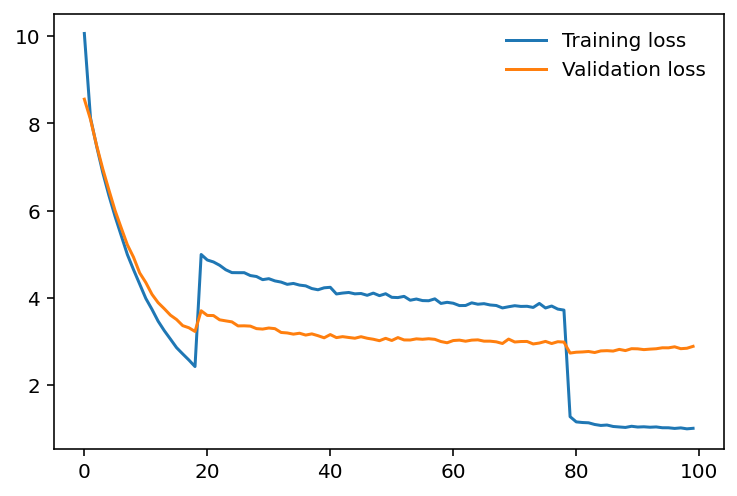

In [12]:
train_losses = np.load('./results/Training_5/Ftp5_train_loss_array.npy')
valid_losses = np.load('./results/Training_5/Ftp5_valid_loss_array.npy')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False) 

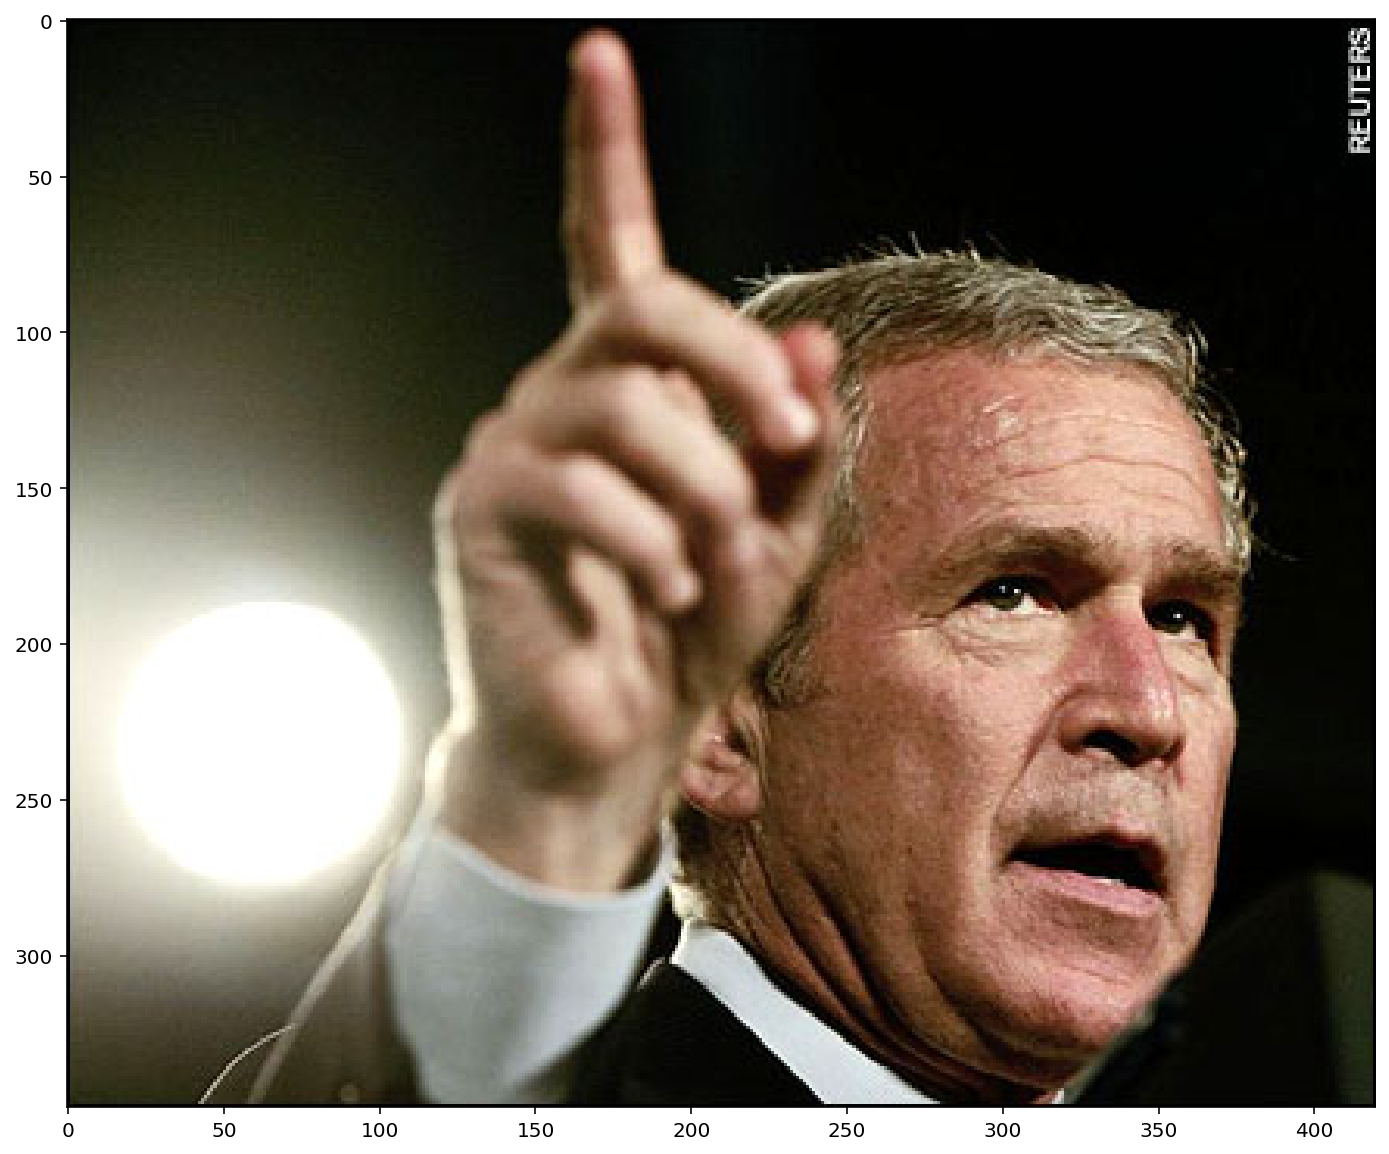

In [13]:
img_path = './data/face_test/big_bushi2.jpg'

# Read test picture
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt 

plt.figure(figsize=(48, 10)) # Set canvas size

img = Image.open(img_path)
plt.imshow(img)

In [14]:
import torch
model_path = './model/Training_5_Res_NLLLoss_1FC_100e_SP.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model=torch.load(model_path)
model.to(device);

In [15]:
from face_crop import face_crop
from torchvision import datasets,transforms 
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

img = Image.open(img_path)

valid_transform = transforms.Compose([
    face_crop(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std),
])



transformed_image = valid_transform(img).float()
with torch.no_grad():
    transformed_image = transformed_image
    transformed_image = transformed_image.unsqueeze(0)
    transformed_image = transformed_image.to(device)
    outputs = model(transformed_image)
#         plt.imshow(transformed_image)
#         print(transformed_image)
outputs = torch.exp(outputs)

In [16]:
top_p, top_k = torch.topk(outputs, 10, dim=1, largest=True, sorted=True, out=None)

In [17]:
import numpy as np
class_names = np.load("class_names.npy")


In [18]:
print('The most similar person is {}.'.format(class_names[top_k[0][0].item()]))
print('Similarity is {:.2%}'.format(top_p[0][0].item()))
print('\n')
print('The second similar person is {}.'.format(class_names[top_k[0][1].item()]))
print('Similarity is {:.2%}'.format(top_p[0][1].item()))
print('\n')
print('The third similar person is {}.'.format(class_names[top_k[0][2].item()]))
print('Similarity is {:.2%}'.format(top_p[0][2].item()))

The most similar person is George_W_Bush.
Similarity is 46.80%


The second similar person is Geoff_Hoon.
Similarity is 10.43%


The third similar person is Kevin_Gil.
Similarity is 6.42%
